# Train

In [11]:
# Kaggle: https://www.kaggle.com/c/simpsons4/

import numpy as np
import pandas as pd 
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import keras
import sys
import random
import shutil

# Import architectures
from keras.applications import xception

from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as im
import time
import datetime

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

In [3]:
# Train phase

tf.keras.backend.set_learning_phase(1) 

In [4]:
# Choose GPU

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

In [8]:
# 1) Path to train, test and kaggle (to submit) datasets

train_dir = "/home/linnik/Downloads/Simp/train/"
test_dir = "/home/linnik/Downloads/Simp/test/" 
kaggle_dir = "/home/linnik/Downloads/Simp/kaggle/" 

In [ ]:
# Make test dataset

for folder in os.listdir(train_dir):
    os.makedirs(test_dir + folder, exist_ok = True)
    
    num_train_photo = len(os.listdir(train_dir + folder))
    while len(os.listdir(test_dir + folder)) > 0.9 * num_train_photo:
        photo = random.choice(os.listdir(train_dir + folder))
        shutil.move(train_dir + folder + "/" + photo, test_dir + folder + "/" + photo)

In [13]:
# 2) Target width and height of input images, number of classes, number of train and test images, batch size, epochs
img_height, img_width = 300, 300
n_classes = len(os.listdir(train_dir))
nb_train_samples = sum([len(os.listdir(train_dir + folder)) for folder in os.listdir(train_dir)])
nb_test_samples = sum([len(os.listdir(test_dir + folder)) for folder in os.listdir(test_dir)])
batch_size = 64
epochs = 100


# 3) Name of file where will be saved trained model
# model_name = ".../Architecture_InputShape_NClasses_date_time.hdf5"
model_name = "/home/linnik/Nets/Simpsons_Xception.hdf5"


# 4) Compile parametrs
loss_ = 'categorical_crossentropy'
optimizer_ = 'adam'
metrics_ = ['acc']

In [14]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    zoom_range = 0.2,
    rotation_range = 5,
    width_shift_range = img_width // 5,
    height_shift_range = img_height // 5,
    horizontal_flip = True,
    vertical_flip = False)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    classes = os.listdir(test_dir))

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    classes = os.listdir(test_dir))

Found 18860 images belonging to 42 classes.
Found 2073 images belonging to 42 classes.


In [17]:
dic_test = test_generator.class_indices
dic_test

{'milhouse_van_houten': 0,
 'moe_szyslak': 1,
 'marge_simpson': 2,
 'miss_hoover': 3,
 'barney_gumble': 4,
 'comic_book_guy': 5,
 'professor_john_frink': 6,
 'principal_skinner': 7,
 'apu_nahasapeemapetilon': 8,
 'charles_montgomery_burns': 9,
 'homer_simpson': 10,
 'groundskeeper_willie': 11,
 'chief_wiggum': 12,
 'lionel_hutz': 13,
 'maggie_simpson': 14,
 'krusty_the_clown': 15,
 'selma_bouvier': 16,
 'bart_simpson': 17,
 'lisa_simpson': 18,
 'fat_tony': 19,
 'otto_mann': 20,
 'patty_bouvier': 21,
 'abraham_grampa_simpson': 22,
 'lenny_leonard': 23,
 'agnes_skinner': 24,
 'gil': 25,
 'cletus_spuckler': 26,
 'snake_jailbird': 27,
 'ned_flanders': 28,
 'edna_krabappel': 29,
 'sideshow_mel': 30,
 'carl_carlson': 31,
 'rainier_wolfcastle': 32,
 'waylon_smithers': 33,
 'disco_stu': 34,
 'nelson_muntz': 35,
 'sideshow_bob': 36,
 'kent_brockman': 37,
 'martin_prince': 38,
 'mayor_quimby': 39,
 'troy_mcclure': 40,
 'ralph_wiggum': 41}

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(300, 300, 3)


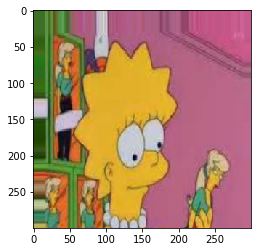

In [18]:
# Check size

for x, y in train_generator:
    plt.imshow(x[0])
    print(y[0])
    print(x[0].shape)
    break

In [19]:
# Create and compile Keras model

def build_model_Xception():
    base_model = xception.Xception(include_top = True, 
                                      weights = None,
                                      input_tensor = None,
                                      input_shape = (img_height, img_width, 3),
                                      pooling = None,
                                      classes = n_classes)
  
    for layer in base_model.layers:
        layer.trainable = True
      
    model = Model(inputs = base_model.input, outputs = base_model.output)
    return model


model = build_model_Xception()
model.compile(loss = loss_, optimizer = optimizer_, metrics = metrics_)

In [22]:
# Callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, min_delta = 1e-4)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)
check = ModelCheckpoint(filepath = model_name, monitor = "val_acc", save_best_only = True)

callbacks_list = [early_stop, reduce_lr, check]

In [24]:
%%time

# Train model

model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

Epoch 1/100
294/294 [==============================] - 486s 2s/step - loss: 0.7526 - acc: 0.8003 - val_loss: 2.2233 - val_acc: 0.6431
Epoch 2/100
294/294 [==============================] - 495s 2s/step - loss: 0.5136 - acc: 0.8582 - val_loss: 2.1309 - val_acc: 0.6491
Epoch 3/100
294/294 [==============================] - 483s 2s/step - loss: 0.4096 - acc: 0.8854 - val_loss: 0.7625 - val_acc: 0.7999
Epoch 4/100
294/294 [==============================] - 483s 2s/step - loss: 0.3323 - acc: 0.9091 - val_loss: 0.6517 - val_acc: 0.8522
Epoch 5/100
294/294 [==============================] - 485s 2s/step - loss: 0.2782 - acc: 0.9235 - val_loss: 0.4813 - val_acc: 0.8761
Epoch 6/100
294/294 [==============================] - 498s 2s/step - loss: 0.2511 - acc: 0.9319 - val_loss: 0.9860 - val_acc: 0.7939
Epoch 7/100
294/294 [==============================] - 483s 2s/step - loss: 0.2254 - acc: 0.9404 - val_loss: 0.5359 - val_acc: 0.8611
Epoch 8/100
294/294 [==============================] - 486s 2s

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 9, in <module>
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/engine/training.py", line 1658, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/engine/training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/utils/data_utils.py", line 603, in get
    inputs = future.get(timeout=30)
  File "/home/linnik/.conda/envs/linnik/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/home/li

KeyboardInterrupt: 

# Test

In [26]:
# Test phase

tf.keras.backend.set_learning_phase(0)

In [27]:
# Load trained model

loaded_model = load_model(model_name)

In [28]:
def Accuracy(test_dir, model, dic):
    n_classes = len(os.listdir(test_dir))
    dic_rev = {v:k for k, v in dic.items()}
    
    right = 0
    wrong = 0

    for folder in os.listdir(test_dir):
        for img in os.listdir(test_dir + "/" + folder):
            imag = im.load_img(test_dir + "/" + folder + "/" + img, target_size = (img_height, img_width))

            photo_ar = im.img_to_array(imag)
            photo_ar = np.expand_dims(photo_ar, axis = 0)
            photo_ar /= 255

            ans = np.argmax(model.predict(photo_ar))


            if folder == dic_rev[ans]:
                right += 1
            else:
                wrong += 1
    
    
    accuracy = right/(right + wrong)
    return accuracy

In [29]:
%%time

accuracy = Accuracy(test_dir, model, dic_test)
print("Accuracy on test set is", accuracy)

Accuracy on test set is 0.9778099372889532
CPU times: user 27.4 s, sys: 2.6 s, total: 30 s
Wall time: 28.8 s


In [36]:
# Make submit csv file

dic_test_rev = {v:k for k, v in dic_test.items()}
ans_df = pd.DataFrame(columns = ["Id", "Expected"])

for img in os.listdir(kaggle_dir):
    imag = im.load_img(kaggle_dir + img, target_size = (img_height, img_width))

    photo_ar = im.img_to_array(imag)
    photo_ar = np.expand_dims(photo_ar, axis = 0)
    photo_ar /= 255

    ans = np.argmax(model.predict(photo_ar))
    
    ans_df.loc[len(ans_df)] = [img, dic_test_rev[ans]]

In [39]:
ans_df

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [37]:
sub_csv_path = "/home/linnik/Downloads/Simp/ans.csv"

ans_df.to_csv(sub_csv_path, index = False)